# Experiments with binary classification diagnosis

In [25]:
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
from numpy import random

## Simulate y_true and y_pred

In [38]:
label_0_size = 20000
label_1_size = 80000

In [48]:
y_pred_0 = random.normal(loc=0, size=label_0_size)
y_pred_1 = random.normal(loc=1, size=label_1_size)

y_pred_0 = np.clip(y_pred_0, 0, 1)
y_pred_1 = np.clip(y_pred_1, 0, 1)

y_pred = np.concatenate((y_pred_0, y_pred_1))

In [49]:
y_true = np.concatenate((np.array([0] * label_0_size), np.array([1] * label_1_size)))

In [50]:
date_index = list(range(label_0_size + label_1_size))
random.shuffle(date_index)

---

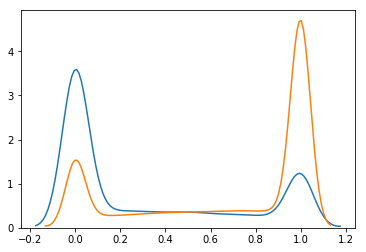

In [51]:
ax = sns.kdeplot(y_pred_0)
ax = sns.kdeplot(y_pred_1, ax=ax)

## AUC

## F1 por threshold

## Matrix de confusao

## Acuracia ao longo do tempo